# Time Series CNN - on the fly augmentation

In [1]:
import os 
import gc
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import pandas as pd 
import time
import pdb
import seaborn as sns
from tqdm import tqdm
from keras.models import Model
from keras import optimizers
from keras import layers
from keras.layers import Activation,Flatten, Dense,SeparableConv1D, Dropout,Conv1D, GlobalMaxPooling1D,MaxPooling1D,GlobalAveragePooling1D,LeakyReLU,BatchNormalization,Input,ReLU
from keras.layers.merge import concatenate
from keras.callbacks import LearningRateScheduler
import keras
from keras.activations import sigmoid, softmax
from functions.generators import data_generator,one_hot_encode, create_XY,permute,skew,add_noise,load_process,prepare_process
from functions.generators import skew_db,inter_mjd,inter_mjd_det,get_void_timeseries,calculate_inputs
import tensorflow as tf
from keras_tqdm import TQDMNotebookCallback
import pickle
from sklearn.ensemble import IsolationForest
from keras import regularizers
from keras.utils import to_categorical
import concurrent.futures
from multiprocessing import Process, Queue, current_process, freeze_support
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)})
plt.figure(figsize=(12,5))

# the following two lines are for changing imported functions, and not needing to restart kernel to use their updated version
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

DATA_DIR = './Data/'
External_Dir='D:/DATA/'
color_map = {0:'g', 1:'r', 2:'c', 3:'m', 4:'y', 5:'k'}
galactic_targets = np.array([6,16,53,65,92])
extragalactic_targets = np.array([15,42,52,62,64,67,88,90,95])
kw = [1,1,1,1,1,2,1,1,1,2,1,1,1,1]
real_targets = np.append(galactic_targets,extragalactic_targets)
Targets = np.append(real_targets,99)

galactic=np.array([1,0,1,0,0,1,0,0,1,0,0,0,1,0])            
ex_galactic = 1-galactic
num_samples=128

C:\Users\kiner\Anaconda3\envs\yuvals\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
real_targets
Targets


array([ 6, 16, 53, 65, 92, 15, 42, 52, 62, 64, 67, 88, 90, 95])

array([ 6, 16, 53, 65, 92, 15, 42, 52, 62, 64, 67, 88, 90, 95, 99])

In [3]:
foldn=4
df_timeseries=pd.read_csv(DATA_DIR+'training_set.csv')
df_training_meta=[]
df_validation_meta=[]
for i in range (foldn):
    df_training_meta.append(pd.read_csv('{}training_meta{}.csv'.format(DATA_DIR,i)))
    df_validation_meta.append(pd.read_csv('{}validation_meta{}.csv'.format(DATA_DIR,i)))


In [4]:
df_training_meta[0].head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,dmjd,ratio,min_flux,max_flux,std_flux
0,46593866,222.233612,-44.201530,324.158369,13.774020,0,0.0,0.0,0.0,NaN,0.182,6,0.903666,0.116667,-0.047212,2.812107,0.386297
1,11912866,110.917969,-29.656013,242.888831,-6.730379,0,0.0,0.0,0.0,NaN,0.230,6,1.091827,0.204082,-0.274050,32.719658,5.695268
2,42606035,99.667969,-9.594068,220.070675,-7.172270,0,0.0,0.0,0.0,NaN,0.526,6,1.084075,0.148438,-0.126974,4.221294,0.648191
3,23068227,124.453125,-54.340912,269.496179,-10.343365,0,0.0,0.0,0.0,NaN,0.280,6,1.090824,0.905109,-2.394836,-0.062959,0.742879
4,39511222,6.780822,-49.117878,313.372827,-67.514527,0,0.0,0.0,0.0,NaN,0.011,6,0.900735,0.105263,-0.066408,0.257408,0.048452


In [5]:
training_meta=pd.read_csv(DATA_DIR+'training_set_metadata.csv')

In [6]:
df_feature_rank=pd.read_csv('D:\DATA\mamas\mamas_feat_rank.csv').sort_values('rank',ascending=False)
mamas_feat=np.load('D:\DATA\mamas\mamas_feat_v1_train.npy')

#stds=np.nanstd(mamas_feat,axis=0)
means=np.nanmean(mamas_feat,axis=0)

maxs=np.nan_to_num(mamas_feat).max(axis=0)-np.nan_to_num(mamas_feat).min(axis=0)

mamas_feat_norm=np.add(np.clip(np.nan_to_num(mamas_feat),-maxs,maxs),-means)

stds=np.nanstd(mamas_feat,axis=0)

mamas_feat_norm=np.divide(mamas_feat_norm,stds)

C:\Users\kiner\Anaconda3\envs\yuvals\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\kiner\Anaconda3\envs\yuvals\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in subtract
  import sys
C:\Users\kiner\Anaconda3\envs\yuvals\lib\site-packages\numpy\lib\nanfunctions.py:1315: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
C:\Users\kiner\Anaconda3\envs\yuvals\lib\site-packages\numpy\lib\nanfunctions.py:1320: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


In [7]:
df_mamas_features=pd.DataFrame(index=training_meta.object_id,data=mamas_feat_norm)

In [8]:
df_training_meta_mamas=[]
df_validation_meta_mamas=[]
for i in range (foldn):
    df_training_meta_mamas.append(df_mamas_features[df_mamas_features.index.isin(df_training_meta[i].object_id.tolist())])
    df_validation_meta_mamas.append(df_mamas_features[df_mamas_features.index.isin(df_validation_meta[i].object_id.tolist() )])


In [9]:
df_feature_rank['mean']=means
df_feature_rank['max']=maxs
df_feature_rank['std']=stds


In [10]:
df_feature_rank.head()

,feature_name,rank,place,mean,max,std
0,diff_mjd_max_detected_over_p_sum,10.541500,0,351.008545,4208.961426,552.621094
1,dist_squared_shifted_flux_max_passband_0_detec...,9.330020,1,0.160670,1.000000,0.144738
2,abs_curve_angle_max_detected_over_p_sum,7.478503,2,2.895284,9.402072,2.603434
3,flux_3_sigma_max_passband_0_detected_normed,7.294360,3,0.173302,23.940300,0.465190
4,diff_mjd_mean_detected_over_p_sum,5.956270,4,152.100128,3443.314697,260.891815


In [11]:
df_feature_rank.to_csv('feature_rank.csv'.format(DATA_DIR),index=False)

In [12]:
for i in range(4):
    df_training_meta[i]['order']=range(df_training_meta[i].shape[0])
    df_training_meta_mamas[i]=df_training_meta_mamas[i].assign(order=df_training_meta[i].sort_values('object_id')['order'].values)
    df_training_meta_mamas[i]=df_training_meta_mamas[i].sort_values('order').fillna(0)
    df_validation_meta[i]['order']=range(df_validation_meta[i].shape[0])
    df_validation_meta_mamas[i]=df_validation_meta_mamas[i].assign(order=df_validation_meta[i].sort_values('object_id')['order'].values)
    df_validation_meta_mamas[i]=df_validation_meta_mamas[i].sort_values('order').fillna(0)

In [13]:
tar_dict=dict(zip(real_targets,range(len(real_targets))))
ty=to_categorical(training_meta.target.map(tar_dict))

In [14]:
wtable=ty.sum(axis=0)/ty.shape[0]
wtable
wtable=wtable/kw
wtable=wtable/wtable.sum()
wtable


array([0.01924057, 0.117737  , 0.00382263, 0.125     , 0.03045362,
       0.0630734 , 0.15201326, 0.02331804, 0.06167176, 0.01299694,
       0.02650357, 0.04714577, 0.29472476, 0.02229868], dtype=float32)

array([0.02000132, 0.12239221, 0.00397377, 0.12994238, 0.03165773,
       0.03278363, 0.15802372, 0.02424002, 0.06411021, 0.00675541,
       0.02755149, 0.04900987, 0.3063779 , 0.02318034])

In [15]:
def mywloss(y_true,y_pred):
    
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [16]:
def score(y_pred,y_true):
    y=np.clip(y_pred,1e-3,1)
    for i in range(y.shape[0]):
        y[i,...]=y[i,...]/y[i,...].sum()
    return -(np.mean(np.mean(y_true*np.log(y),axis=0)/wtable))

In [17]:
from keras import backend as K
from keras.engine.topology import Layer

class MySwitch(Layer):

    def __init__(self ,split,**kwargs):
        self.split=split
        super(MySwitch, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        assert self.split<=input_shape[1][-1]
        self.nsplit=input_shape[1][-1]
        # Create a trainable weight variable for this layer.
        super(MySwitch, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        assert isinstance(x, list)
        x0=tf.equal(x[0],tf.zeros_like(x[0]))
        x1=tf.logical_not(x0)
        xt0=tf.tile(x0,[1,self.split])
        xt1=tf.tile(x1,[1,self.nsplit-self.split])
        xf=tf.concat([xt0,xt1],axis=-1)
        return tf.where(xf,x[1],-1e4*tf.ones_like(x[1]))

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape_a, shape_b = input_shape
        return (shape_b[0],shape_b[1])


In [18]:
def build_model14():
    input_timeseries = Input(shape=(num_samples, 6,),name='input_timeseries')
    input_timeseries0 = Input(shape=(num_samples, 6,),name='input_timeseries0')
    input_meta = Input(shape=(4,),name='input_meta')
    input_gal = Input(shape=(1,),name='input_gal')
    _series=concatenate([input_timeseries,input_timeseries0])
    x = Conv1D(256,8,padding='same',name='Conv1')(_series)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(256,5,padding='same',name='Conv2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(256,3,padding='same',name='Conv5')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    #x = Dropout(0.2)(x)
    x = GlobalMaxPooling1D()(x)
    x1 = Dense(16,activation='relu',name='dense0')(input_meta)
    x1 = Dense(32,activation='relu',name='dense1')(x1)
    xc = concatenate([x,x1],name='concat')
    x = Dense(256,activation='relu',name='features')(xc)
    x = Dense(real_targets.shape[0],name='bout')(x)
    x = MySwitch(galactic_targets.shape[0])([input_gal,x])
    out = Activation('softmax',name='out')(x)
    model=Model([input_timeseries,input_timeseries0,input_meta,input_gal],out)
    return model
build_model14().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_timeseries (InputLayer)   (None, 128, 6)       0                                            
__________________________________________________________________________________________________
input_timeseries0 (InputLayer)  (None, 128, 6)       0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 12)      0           input_timeseries[0][0]           
                                                                 input_timeseries0[0][0]          
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 128, 256)     24832       concatenate_1[0][0]              
__________

In [19]:
def build_model15():
    input_timeseries = Input(shape=(num_samples, 6,),name='input_timeseries')
    input_timeseries0 = Input(shape=(num_samples, 6,),name='input_timeseries0')
    input_meta = Input(shape=(6,),name='input_meta')
    input_gal = Input(shape=(1,),name='input_gal')
    _series=concatenate([input_timeseries,input_timeseries0])
    x = Conv1D(256,8,padding='same',name='Conv1')(_series)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(256,5,padding='same',name='Conv2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(256,3,padding='same',name='Conv5')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    #x = Dropout(0.2)(x)
    x = GlobalMaxPooling1D()(x)
    x1 = Dense(16,activation='relu',name='dense0')(input_meta)
    x1 = Dense(32,activation='relu',name='dense1')(x1)
    xc = concatenate([x,x1],name='concat')
    x = Dense(256,activation='relu',name='features')(xc)
    x = Dense(real_targets.shape[0],name='bout')(x)
    x = MySwitch(galactic_targets.shape[0])([input_gal,x])
    out = Activation('softmax',name='out')(x)
    model=Model([input_timeseries,input_timeseries0,input_meta,input_gal],out)
    return model
build_model15().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_timeseries (InputLayer)   (None, 128, 6)       0                                            
__________________________________________________________________________________________________
input_timeseries0 (InputLayer)  (None, 128, 6)       0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 128, 12)      0           input_timeseries[0][0]           
                                                                 input_timeseries0[0][0]          
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 128, 256)     24832       concatenate_2[0][0]              
__________

In [20]:
def build_model16():
    input_timeseries = Input(shape=(num_samples, 6,),name='input_timeseries')
    input_timeseries0 = Input(shape=(num_samples, 6,),name='input_timeseries0')
    input_timeseriese = Input(shape=(num_samples, 6,),name='input_timeseriese')
    input_meta = Input(shape=(6,),name='input_meta')
    input_gal = Input(shape=(1,),name='input_gal')
    _series=concatenate([input_timeseries,input_timeseries0,input_timeseriese])
    x = Conv1D(256,8,padding='same',name='Conv1')(_series)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(256,5,padding='same',name='Conv2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(256,3,padding='same',name='Conv5')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    #x = Dropout(0.3)(x)
    x = GlobalMaxPooling1D()(x)
    x1 = Dense(16,activation='relu',name='dense0')(input_meta)
    x1 = Dense(32,activation='relu',name='dense1')(x1)
    xc = concatenate([x,x1],name='concat')
    x = Dense(256,activation='relu',name='features')(xc)
    x = Dense(real_targets.shape[0],name='bout')(x)
    x = MySwitch(galactic_targets.shape[0])([input_gal,x])
    out = Activation('softmax',name='out')(x)
    model=Model([input_timeseries,input_timeseries0,input_timeseriese,input_meta,input_gal],out)
    return model
build_model16().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_timeseries (InputLayer)   (None, 128, 6)       0                                            
__________________________________________________________________________________________________
input_timeseries0 (InputLayer)  (None, 128, 6)       0                                            
__________________________________________________________________________________________________
input_timeseriese (InputLayer)  (None, 128, 6)       0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 128, 18)      0           input_timeseries[0][0]           
                                                                 input_timeseries0[0][0]          
          

In [21]:
def build_model17():
    input_timeseries = Input(shape=(num_samples, 6,),name='input_timeseries')
    input_timeseries0 = Input(shape=(num_samples, 6,),name='input_timeseries0')
    input_timeseriese = Input(shape=(num_samples, 6,),name='input_timeseriese')
    input_timeseriesv = Input(shape=(num_samples, 6,),name='input_timeseriesv')
    input_meta = Input(shape=(6,),name='input_meta')
    input_gal = Input(shape=(1,),name='input_gal')
    _series=concatenate([input_timeseries,input_timeseries0,input_timeseriese,input_timeseriesv])
    x = Conv1D(256,8,padding='same',name='Conv1')(_series)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(256,5,padding='same',name='Conv2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(256,3,padding='same',name='Conv5')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    #x = Dropout(0.3)(x)
    x = GlobalMaxPooling1D()(x)
    x1 = Dense(16,activation='relu',name='dense0')(input_meta)
    x1 = Dense(32,activation='relu',name='dense1')(x1)
    xc = concatenate([x,x1],name='concat')
    x = Dense(256,activation='relu',name='features')(xc)
    x = Dense(real_targets.shape[0],name='bout')(x)
    x = MySwitch(galactic_targets.shape[0])([input_gal,x])
    out = Activation('softmax',name='out')(x)
    model=Model([input_timeseries,input_timeseries0,input_timeseriese,input_timeseriesv,input_meta,input_gal],out)
    return model
build_model17().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_timeseries (InputLayer)   (None, 128, 6)       0                                            
__________________________________________________________________________________________________
input_timeseries0 (InputLayer)  (None, 128, 6)       0                                            
__________________________________________________________________________________________________
input_timeseriese (InputLayer)  (None, 128, 6)       0                                            
__________________________________________________________________________________________________
input_timeseriesv (InputLayer)  (None, 128, 6)       0                                            
__________________________________________________________________________________________________
concatenat

In [22]:
def build_top(ntop,convout,n_first=64):
    input_meta = Input(shape=(ntop,),name='input_meta')
    input_gal = Input(shape=(1,),name='input_gal')
    x = BatchNormalization()(convout)
    x = LeakyReLU(alpha=0.1)(x)
#    x = Dropout(0.3)(x)
    x = GlobalMaxPooling1D()(x)
    x1 = Dense(n_first,activation='relu',name='dense0')(input_meta)
#    x1 = Dropout(0.4)(x1)
#    x1 = BatchNormalization()(x1)
#    x1 = Dense(64,activation='relu',name='dense1')(x1)
    x1 = Dropout(0.2)(x1)  #was 0.2
    x1 = BatchNormalization()(x1)
    x1 = Dense(64,activation='relu',name='dense2')(x1)
#   x1 = Dropout(0.5)(x1)
#    x1 = BatchNormalization()(x1)
    xc = concatenate([x,x1],name='concat')
    x = Dense(256,activation='relu',name='features')(xc)
    x = Dense(real_targets.shape[0],name='bout')(x)
    x = MySwitch(galactic_targets.shape[0])([input_gal,x])
    out = Activation('softmax',name='out')(x)
    return [input_meta,input_gal],out


In [23]:
def model_retop(model,ntop,last_conv_layer_name='Conv5',n_first=64):
    convout = model.get_layer(name=last_conv_layer_name).output
    inputs=[]
    for inp in model.inputs:
        if 'timeseries' in inp.name:
            inputs.append(inp)
    dinputs,out=build_top(ntop,convout,n_first=n_first)
    inputs=inputs+dinputs
    topmodel=Model(inputs,out)
    return topmodel
model_retop(build_model14(),8).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_timeseries (InputLayer)   (None, 128, 6)       0                                            
__________________________________________________________________________________________________
input_timeseries0 (InputLayer)  (None, 128, 6)       0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 128, 12)      0           input_timeseries[0][0]           
                                                                 input_timeseries0[0][0]          
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 128, 256)     24832       concatenate_5[0][0]              
__________

In [24]:
def model_tap(model,last_conv_layer_name='Conv5'):
    convout = model.get_layer(name=last_conv_layer_name).output
    x = BatchNormalization()(convout)
    x = LeakyReLU(alpha=0.1)(x)
    out2 = GlobalMaxPooling1D()(x)
    out=model.get_layer(name='out').output
    out1=model.get_layer(name='out').input
    return Model(model.inputs,outputs=[out,out1,out2])
model_tap(build_model14()).summary()    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_timeseries (InputLayer)   (None, 128, 6)       0                                            
__________________________________________________________________________________________________
input_timeseries0 (InputLayer)  (None, 128, 6)       0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 128, 12)      0           input_timeseries[0][0]           
                                                                 input_timeseries0[0][0]          
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 128, 256)     24832       concatenate_6[0][0]              
__________

In [25]:
opt=optimizers.Adam()

opt.lr=1e-4

In [26]:
meta_cols=['hostgal_photoz','dmjd','std_flux','distmod']
col_weights=[1.0,1.0,1.0,1.0]

In [27]:
for i in range(4):
        df_validation_meta[i]=df_validation_meta[i].sort_values('object_id').reset_index(drop=True).copy()
        df_training_meta[i]=df_training_meta[i].sort_values('object_id').reset_index(drop=True).copy()

In [29]:
# Training

myhist={'val_loss':[],
        'val_categorical_accuracy':[],
        'loss':[],
        'categorical_accuracy':[],
        'lr':[],
        'score':[]}
fold=tqdm_notebook([0,1,2,3],desc='fold:')
for f in fold:
    smin1=100
    validate_timeseries,validate_timeseries0,validate_void,validate_meta,validate_switch,validate_y=\
        calculate_inputs(df_timeseries,df_validation_meta[f],meta_cols,col_weights,real_targets,length=num_samples,aug=None,return_y=True)
    tq=tqdm_notebook(range(4),desc='full:')
    for p in tq:
        lr=np.array([1e-3,1e-3,1e-3,3e-4,3e-4,3e-4,1e-4,1e-4,1e-4,3e-4,3e-4,3e-4,1e-4,1e-4,1e-4,3e-5,3e-5,3e-5,
             1e-3,3e-4,1e-4,3e-5,3e-5,3e-5,1e-5,1e-5,1e-5,3e-6,3e-6,3e-6,1e-5,1e-5,1e-5,3e-6,
                                     3e-6,3e-6,1e-5,1e-5,1e-5,3e-6,3e-6,3e-6])

        smin=100
        executor=concurrent.futures.ProcessPoolExecutor(max_workers=4)
        futurs=[]
        model16 = build_model16()
        model=model_retop(model16,4)        
#        model.load_weights('model16fr4_{}.weights'.format(f))
        model.compile(opt,loss=mywloss,metrics=['categorical_accuracy'])
        aug_vals={'shift':32, 'skew':0.05,'sample':0.85}
        for k in range(lr.shape[0]):
            futurs.append(executor.submit(calculate_inputs,df_timeseries,df_training_meta[f],\
                                          meta_cols,col_weights,real_targets,length=num_samples,aug=aug_vals,return_y=True))
        tq1=tqdm_notebook(zip(lr,concurrent.futures.as_completed(futurs)),leave=False,total=lr.shape[0])

        for opt.lr,future in tq1:
            sr,sr0,srv,train_meta,train_switch,train_y=future.result(timeout=200)
            _=gc.collect()
            #print(time.time()-strt)
            history=model.fit([sr,sr0,srv,train_meta,train_switch],train_y,batch_size=64,epochs=1,
                            validation_data=([validate_timeseries,validate_timeseries0,validate_void,
                                              validate_meta,validate_switch],validate_y),
                                                verbose=0 )
            y=model.predict([validate_timeseries,validate_timeseries0,validate_void,
                                              validate_meta,validate_switch],batch_size=64)

            s=score(y,validate_y)
            #print(s)
            myhist['val_loss'].extend(history.history['val_loss'])
            myhist['val_categorical_accuracy'].extend(history.history['val_categorical_accuracy'])
            myhist['loss'].extend(history.history['loss'])
            myhist['categorical_accuracy'].extend(history.history['categorical_accuracy'])
            myhist['lr'].append(opt.lr)
            myhist['score'].append(s)
            if s<smin:
                smin=s
                weights_min=model.get_weights()
            tq1.set_postfix(lr=opt.lr,current_score=s,loss=history.history['loss'][0],val_loss=history.history['val_loss'][0])
            tq.set_postfix(temp_min=smin,total_min=min(smin,smin1))
        executor.shutdown(wait=True)

        #weights_min1=weights_min.copy()            
        lr=np.array([3e-6,3e-6,3e-6,3e-5,3e-6,3e-6,3e-5,3e-6,3e-4,3e-5,3e-6,3e-6,3e-5,3e-6,3e-6,3e-5,3e-6,3e-6])
        aug_vals={'shift':128, 'skew':0.05,'sample':0.85}

        executor=concurrent.futures.ProcessPoolExecutor(max_workers=4)
        futurs=[]

        model16 = build_model16()
        model=model_retop(model16,4)        
        model.set_weights(weights_min)
        model.compile(opt,loss=mywloss,metrics=['categorical_accuracy'])
        for k in range(lr.shape[0]):
            futurs.append(executor.submit(calculate_inputs,df_timeseries,df_training_meta[f],meta_cols,\
                                          col_weights,real_targets,length=num_samples,aug=aug_vals,return_y=True))
        tq2=tqdm_notebook(zip(lr,concurrent.futures.as_completed(futurs)),leave=False,total=lr.shape[0])
        for opt.lr,future in tq2:

            sr,sr0,srv,train_meta,train_switch,train_y=future.result(timeout=200)
            _=gc.collect()
            history=model.fit([sr,sr0,srv,train_meta,train_switch],train_y,batch_size=256,epochs=1,
                            validation_data=([validate_timeseries,validate_timeseries0,validate_void,
                                              validate_meta,validate_switch],validate_y),
                                                verbose=0 )
            y=model.predict([validate_timeseries,validate_timeseries0,validate_void,
                                              validate_meta,validate_switch],batch_size=64)
            s=score(y,validate_y)
            #print(s)
            myhist['val_loss'].extend(history.history['val_loss'])
            myhist['val_categorical_accuracy'].extend(history.history['val_categorical_accuracy'])
            myhist['loss'].extend(history.history['loss'])
            myhist['categorical_accuracy'].extend(history.history['categorical_accuracy'])
            myhist['lr'].append(opt.lr)
            myhist['score'].append(s)
            if s<smin:
                smin=s
                weights_min=model.get_weights()
            tq2.set_postfix(lr=opt.lr,current_score=s,loss=history.history['loss'][0],val_loss=history.history['val_loss'][0])
            tq.set_postfix(temp_min=smin,total_min=min(smin,smin1))
        executor.shutdown(wait=True)
        if smin<smin1:
            smin1=smin
            weights_min1=weights_min.copy()

    model.set_weights(weights_min1)
    model.save_weights('model16fr4q2_{}.weights'.format(f))
    y=model.predict([validate_timeseries,validate_timeseries0,validate_void,
                                              validate_meta,validate_switch],batch_size=64)

    score(y,validate_y)


HBox(children=(IntProgress(value=0, description='fold:', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, description='full:', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

0.5418935990915522

HBox(children=(IntProgress(value=0, description='full:', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

0.5521202789593197

HBox(children=(IntProgress(value=0, description='full:', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

0.541464659828559

HBox(children=(IntProgress(value=0, description='full:', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

0.5789409145521438

In [30]:
ys=[]
yv=[]
#model = build_model15()
model16 = build_model16()
model=model_retop(model16,4)
for f in [0,1,2,3]:
    validate_timeseries,validate_timeseries0,validate_void,validate_meta,validate_switch,validate_y=\
        calculate_inputs(df_timeseries,df_validation_meta[f],meta_cols,col_weights,real_targets,length=num_samples,aug=None,return_y=True)

    model.load_weights('model16fr4q_{}.weights'.format(f))
    
    y=model.predict([validate_timeseries,validate_timeseries0,validate_void,
                                              validate_meta,validate_switch],batch_size=64)

    score(y,validate_y)
    ys.append(y.copy())
    yv.append(validate_y.copy())
score(np.concatenate(ys),np.concatenate(yv))

0.5418935990915522

0.5494089737632141

0.541464659828559

0.573316249675152

0.5515427988082393

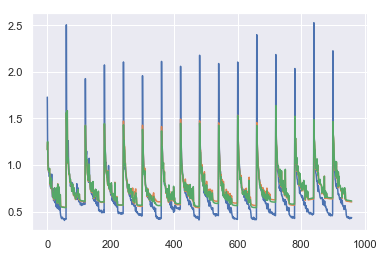

In [31]:
plt.plot(myhist['loss'])
plt.plot(myhist['val_loss'])
plt.plot(myhist['score'])

In [32]:
df_test_meta=pd.read_csv(DATA_DIR+'test_set_metadata.csv')

In [33]:
mamas_feat_test=np.load('D:\DATA\mamas\mamas_feat_v2_test.npy')
df_feature_rank=pd.read_csv('feature_rank.csv'.format(DATA_DIR))
df_feature_rank.head()

df_feature_rank=pd.read_csv('feature_rank.csv'.format(DATA_DIR)).iloc[:64]
#stds=np.nanstd(mamas_feat,axis=0)

mamas_feat_norm=np.add(np.clip(np.nan_to_num(mamas_feat_test),-df_feature_rank['max'].values,df_feature_rank['max'].values),-df_feature_rank['mean'].values)

mamas_feat_norm=np.divide(mamas_feat_norm,df_feature_rank['std'].values)

,feature_name,rank,place,mean,max,std
0,diff_mjd_max_detected_over_p_sum,10.541500,0,351.008540,4208.961400,552.621100
1,dist_squared_shifted_flux_max_passband_0_detec...,9.330020,1,0.160670,1.000000,0.144738
2,abs_curve_angle_max_detected_over_p_sum,7.478503,2,2.895284,9.402072,2.603434
3,flux_3_sigma_max_passband_0_detected_normed,7.294360,3,0.173302,23.940300,0.465190
4,diff_mjd_mean_detected_over_p_sum,5.956270,4,152.100130,3443.314700,260.891800


In [34]:
df_mamas_features_test=pd.DataFrame(index=df_test_meta.object_id,data=mamas_feat_norm).reset_index()

In [35]:
#with mamas
#cols=['hostgal_photoz','std_flux']
#cols.extend(range(16))
cols=['hostgal_photoz','dmjd','std_flux','distmod'] #without mamas
#cols

In [38]:
cols=['hostgal_photoz','dmjd','std_flux','distmod']
col_weights=[1.0,1.0,1.0,1.0]
cols
models=[]
res_dfs=[]
res_dfps=[]
queue_length=4
chunksize=500000
for f in range(4):
    modelb = build_model16()
    modelp=model_retop(modelb,4)
    model=model_tap(modelp)
    modelp.load_weights('model16fr4q_{}.weights'.format(f))
    models.append(model)
    res_dfs.append([])
    res_dfps.append([])
timeseries_file=DATA_DIR+'test_set.csv'
df_test_meta=pd.read_csv(DATA_DIR+'test_set_metadata.csv')
df_test_extra = pd.read_csv(DATA_DIR+'test_extra.csv')
df_test_meta=df_test_meta.merge(df_test_extra,on='object_id',how='left').sort_values('object_id')
in_queue =  Queue(queue_length)
out_queue =  Queue(queue_length)
print('start')
Process(target=load_process, args=(df_test_meta,timeseries_file,in_queue,queue_length,chunksize)).start()
for q in range(queue_length):
    Process(target=prepare_process,args=(cols,col_weights,real_targets,in_queue,out_queue,num_samples)).start()
print('running')
tq=tqdm_notebook(desc='objects:',total=df_test_meta.shape[0])
for st in range(queue_length):
    for object_id,timeseries,timeseries0,void,meta,sw in iter(out_queue.get, 'STOPED'):
        for f in range(4):
            [y,yp,yf]=models[f].predict([timeseries,timeseries0,void,meta,sw],batch_size=64)
            res_dfs[f].append(pd.DataFrame(index=object_id, data=y, columns=['class_%d' % k for k in real_targets]))
            res_dfps[f].append(pd.DataFrame(index=object_id, data=yp, columns=['class_%d' % k for k in real_targets]))
        tq.update(meta.shape[0])
df_res=[]
df_resp=[]
for f in range(4):
    df_res.append(pd.concat(res_dfs[f]).sort_index())
    df_resp.append(pd.concat(res_dfps[f]).sort_index())


['hostgal_photoz', 'dmjd', 'std_flux', 'distmod']

start
running


HBox(children=(IntProgress(value=0, description='objects:', max=3492890), HTML(value='')))

In [39]:
for f in range(4):
    df_res[f].to_csv('{}res1/pred16r4q_{}.csv'.format(External_Dir,f))
    df_resp[f].to_csv('{}res1/pred16rp4q_{}.csv'.format(External_Dir,f))

In [40]:
for f in range(4):
    df_res[f]['class_99']=(1-df_res[f].max(axis=1))

for f in range(4):
    m=df_res[f]['class_99'].mean()
    df_res[f]['class_99']=df_res[f]['class_99']/m/8
    df_res[f]=df_res[f].div(df_res[f].sum(axis=1), axis=0)


In [41]:
df_rest=(df_res[0]+df_res[1]+df_res[2]+df_res[3])/4

df_rest.head()

df_rest=df_rest.clip(1e-3,1)

df_rest=df_rest.div(df_rest.sum(axis=1), axis=0)

df_rest.sample(20)

,class_6,class_16,class_53,class_65,class_92,class_15,class_42,class_52,class_62,class_64,class_67,class_88,class_90,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.0,0.0,0.0,0.0,0.0,0.000031,0.661750,0.061582,0.166621,2.474877e-08,0.003512,0.000009,0.008560,0.021373,0.076561
14,0.0,0.0,0.0,0.0,0.0,0.001137,0.199629,0.115450,0.013136,2.311646e-05,0.007960,0.000440,0.545773,0.013522,0.102930
17,0.0,0.0,0.0,0.0,0.0,0.000212,0.288093,0.177768,0.021310,1.234994e-04,0.001393,0.000014,0.376796,0.011636,0.122654
23,0.0,0.0,0.0,0.0,0.0,0.000130,0.086644,0.046383,0.124279,1.645082e-05,0.257798,0.000002,0.307015,0.028750,0.148983
34,0.0,0.0,0.0,0.0,0.0,0.001262,0.062872,0.329083,0.013836,4.278123e-07,0.021855,0.000022,0.428474,0.014321,0.128275


,class_6,class_16,class_53,class_65,class_92,class_15,class_42,class_52,class_62,class_64,class_67,class_88,class_90,class_95,class_99
object_id,,,,,,,,,,,,,,,
109520686,0.000995,0.000995,0.000995,0.000995,0.000995,0.010690,0.063377,0.036011,0.039045,0.446707,0.031390,0.005622,0.149934,0.100207,0.112041
55702866,0.000995,0.000995,0.000995,0.000995,0.000995,0.042260,0.111293,0.097353,0.035189,0.002561,0.044560,0.066120,0.441043,0.029620,0.125025
53038648,0.000987,0.000987,0.000987,0.986184,0.000987,0.000987,0.000987,0.000987,0.000987,0.000987,0.000987,0.000987,0.000987,0.000987,0.000987
23585850,0.000993,0.000993,0.000993,0.000993,0.000993,0.000993,0.068968,0.100385,0.039087,0.001178,0.251664,0.000993,0.324840,0.062621,0.144304
11777945,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.986192,0.000986,0.000986,0.000986
95713015,0.000995,0.000995,0.000995,0.000995,0.000995,0.002294,0.065494,0.383860,0.016053,0.001033,0.069672,0.005551,0.317211,0.001374,0.132483
57145312,0.000991,0.000991,0.000991,0.000991,0.000991,0.000991,0.041130,0.217390,0.004067,0.000991,0.019808,0.000991,0.625958,0.000991,0.082724
60069315,0.000993,0.000993,0.000993,0.000993,0.000993,0.002000,0.146458,0.238371,0.062922,0.085212,0.054870,0.000993,0.248597,0.000993,0.154616
76824687,0.000995,0.000995,0.000995,0.000995,0.000995,0.095596,0.193323,0.071866,0.273471,0.016363,0.034557,0.008123,0.067405,0.071993,0.162327


In [42]:
df_rest.to_csv('{}res1/submit81.csv'.format(External_Dir),float_format='%.4f')